<a href="https://colab.research.google.com/github/julwdo/thesis/blob/main/01_codes/03_nlp_project_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", "{:.6f}".format)

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew

sns.set(style="whitegrid")

def plot_numeric(df, feature, label_col="label", bins=50, palette=None, auto_log=True):
  """
  Plot normalized histogram of a numeric feature by label.
  Automatically log-transforms highly skewed features if auto_log=True.
  """
  data = df.copy()
  plot_feature = feature

  # Determine if log-transform is needed
  if auto_log:
      feature_skew = skew(data[feature].dropna())
      if feature_skew > 2:
          plot_feature = "log_" + feature
          data[plot_feature] = np.log1p(data[feature])

  # Compute weights to normalize counts per label
  weights = data.groupby(label_col).transform(lambda x: 1 / len(x))

  plt.figure(figsize=(8, 5))
  sns.histplot(
      data=data,
      x=plot_feature,
      hue=label_col,
      bins=bins,
      weights=weights[feature],
      palette=palette or {1: "red", 0: "blue"},
      alpha=0.6
  )
  plt.xlabel(feature)
  plt.ylabel("Relative frequency")
  plt.title(f"{feature} by {label_col} (normalized)")
  plt.show()

def plot_boolean(df, feature, label_col="label", palette=None):
    """
    Plot relative proportions of a boolean feature by label.
    """

    # Compute proportions per label
    prop_df = (
        df
        .groupby(label_col)[feature]
        .value_counts(normalize=True)
        .rename("proportion")
        .reset_index()
    )

    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=prop_df,
        x=feature,
        y="proportion",
        hue=label_col,
        palette=palette or {1: "red", 0: "blue"}
    )

    plt.xlabel(feature)
    plt.ylabel("Proportion")
    plt.title(f"{feature} by label")
    plt.show()

In [4]:
import pyarrow.parquet as pq

path = "/content/drive/MyDrive/twibot-22/processed"

tweet_features = pd.read_parquet(f"{path}/tweet_features.parquet", engine='pyarrow')

In [5]:
n_rows, n_columns = tweet_features.shape
print(f"The dataset contains {n_rows} rows and {n_columns} columns.")

The dataset contains 1048873 rows and 11 columns.


In [6]:
tweet_features.head()

,author_id,id,text,created_at,is_reply,is_sensitive,like_count,quote_count,reply_count,retweet_count,label
0,u1001495628738957312,t1502310945158275074,"Join us for a special screening of the documentary #SAPELO and a Q&amp;A with the filmmakers on Thursday, March 31 at the <USER>!📽️🇨🇭 <USER> <USER> <URL>",2022-03-11 15:50:15+00:00,0,0,1,0.000000,0.000000,1,human
1,u1002590470097154048,t1459274835377500161,Looking forward to meeting the final chapter👀👀 <URL>,2021-11-12 21:40:07+00:00,0,0,0,NaN,NaN,0,bot
2,u1002590470097154048,t1405835036847443969,"RT <USER>: Our new service robot is getting ready to be used in amazing researches on ""generalizable perception and manipulation…",2021-06-18 10:29:26+00:00,0,0,0,NaN,NaN,1,bot
3,u1002590470097154048,t1401642372044296199,"RT <USER>: I'm happy to be a finalist for the ICRA Best Paper Award &amp; grateful to coauthors <USER>, Zhiyong, <USER>. I t…",2021-06-06 20:49:17+00:00,0,0,0,NaN,NaN,3,bot
4,u1002590470097154048,t1379337484384014336,"RT <USER>: The Conference on #Robot #Learning 2021 will be held on Nov 8-11 in London, UK &amp; virtually. Exciting new changes, including:…",2021-04-06 07:37:37+00:00,0,0,0,NaN,NaN,44,bot


In [7]:
tweet_features['label'] = tweet_features['label'].map({'human': 0, 'bot': 1})

In [8]:
# Check for missing values
if tweet_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = tweet_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / tweet_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

Missing values found in the dataset.

Summary of missing values:
             Missing Count  Missing Percentage
quote_count         796093           75.899847
reply_count         796093           75.899847


In [9]:
bots = tweet_features[tweet_features['label'] == 1]
humans = tweet_features[tweet_features['label'] == 0]

def check_missing(df, label):
    if df.isnull().any().any():
        print(f"\nMissing values found for {label}:")
        na_summary = df.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
        na_summary['Missing Percentage'] = (na_summary['Missing Count'] / df.shape[0]) * 100
        print(na_summary)
    else:
        print(f"\nNo missing values found for {label}.")

check_missing(bots, "bots")
check_missing(humans, "humans")


Missing values found for bots:
             Missing Count  Missing Percentage
quote_count          86243           91.558910
reply_count          86243           91.558910

Missing values found for humans:
             Missing Count  Missing Percentage
quote_count         709850           74.354835
reply_count         709850           74.354835


In [10]:
tweet_features['quote_count_missing'] = tweet_features['quote_count'].isnull().astype(bool)
tweet_features['reply_count_missing'] = tweet_features['reply_count'].isnull().astype(bool)

In [11]:
tweet_features.dtypes

,0
author_id,object
id,object
text,object
created_at,object
is_reply,int32
is_sensitive,int32
like_count,int64
quote_count,float64
reply_count,float64
retweet_count,int64


In [12]:
tweet_features["is_reply"] = tweet_features["is_reply"].astype(bool)
tweet_features["is_sensitive"] = tweet_features["is_sensitive"].astype(bool)

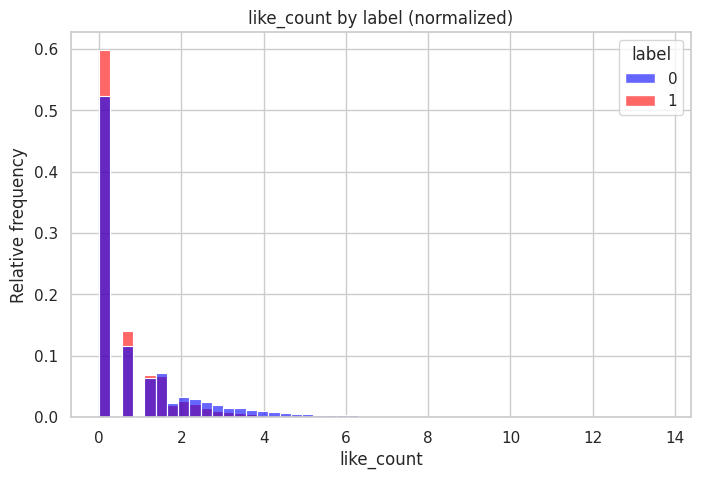

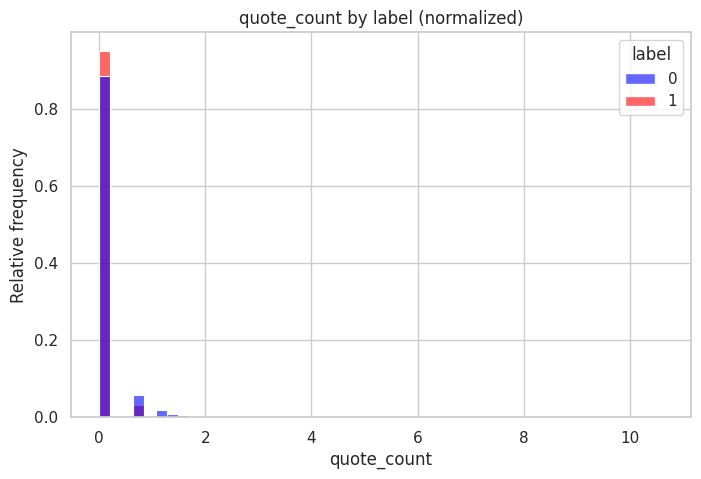

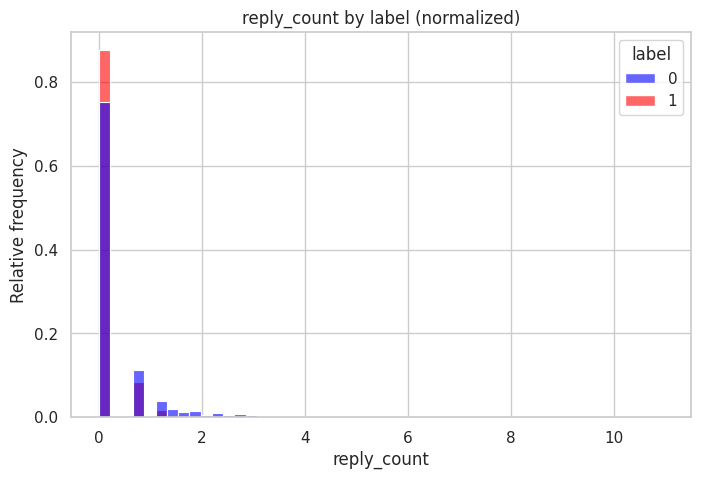

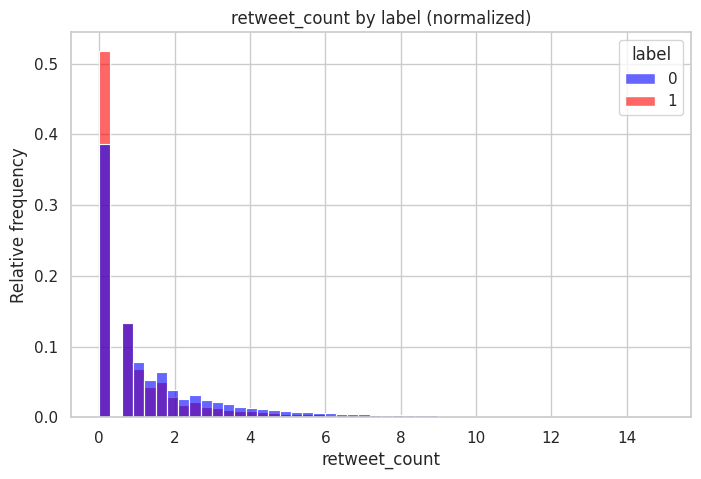

In [13]:
numeric_cols = [col for col in tweet_features.select_dtypes(include=np.number).columns if col != "label"]

for col in numeric_cols:
  df_plot = tweet_features[[col, 'label']].dropna(subset=[col])
  plot_numeric(df_plot, col)

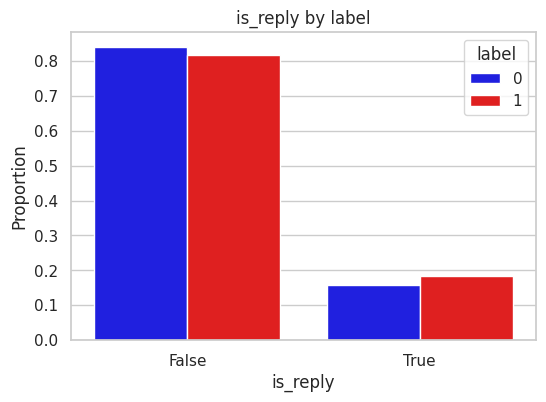

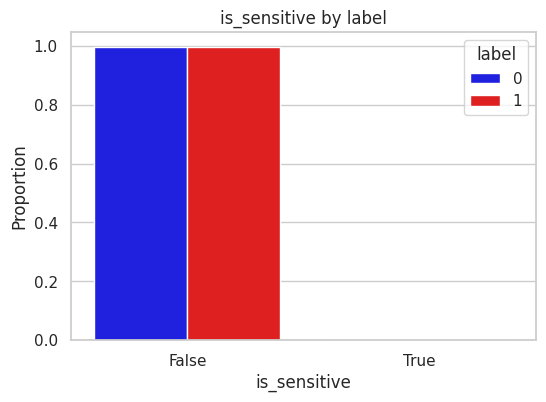

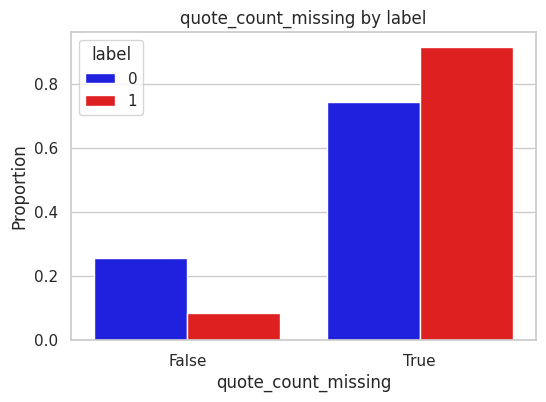

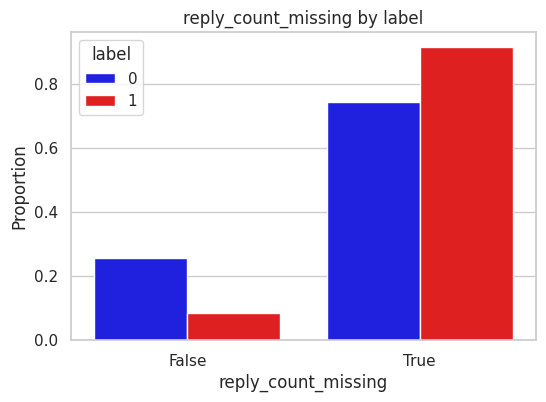

In [14]:
bool_cols = tweet_features.select_dtypes(include=['bool']).columns

for col in bool_cols:
  plot_boolean(tweet_features, col)

In [15]:
for col in ['quote_count', 'reply_count']:
  tweet_features[col] = tweet_features[col].fillna(0)

In [16]:
# Check for missing values
if tweet_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = tweet_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / tweet_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


In [19]:
tweet_features.head(20)

,author_id,id,text,created_at,is_reply,is_sensitive,like_count,quote_count,reply_count,retweet_count,label,quote_count_missing,reply_count_missing
0,u1001495628738957312,t1502310945158275074,"Join us for a special screening of the documentary #SAPELO and a Q&amp;A with the filmmakers on Thursday, March 31 at the <USER>!📽️🇨🇭 <USER> <USER> <URL>",2022-03-11 15:50:15+00:00,False,False,1,0.000000,0.000000,1,0,False,False
1,u1002590470097154048,t1459274835377500161,Looking forward to meeting the final chapter👀👀 <URL>,2021-11-12 21:40:07+00:00,False,False,0,0.000000,0.000000,0,1,True,True
2,u1002590470097154048,t1405835036847443969,"RT <USER>: Our new service robot is getting ready to be used in amazing researches on ""generalizable perception and manipulation…",2021-06-18 10:29:26+00:00,False,False,0,0.000000,0.000000,1,1,True,True
3,u1002590470097154048,t1401642372044296199,"RT <USER>: I'm happy to be a finalist for the ICRA Best Paper Award &amp; grateful to coauthors <USER>, Zhiyong, <USER>. I t…",2021-06-06 20:49:17+00:00,False,False,0,0.000000,0.000000,3,1,True,True
4,u1002590470097154048,t1379337484384014336,"RT <USER>: The Conference on #Robot #Learning 2021 will be held on Nov 8-11 in London, UK &amp; virtually. Exciting new changes, including:…",2021-04-06 07:37:37+00:00,False,False,0,0.000000,0.000000,44,1,True,True
5,u1002590470097154048,t1375413282966753290,<USER> <USER> <USER> <USER> Congratulations Weijia🎉,2021-03-26 11:44:15+00:00,True,False,1,0.000000,0.000000,0,1,True,True
6,u1002590470097154048,t1375413169594699778,"RT <USER>: A guiding vector field is typically used for the guidance of a single vehicle. I, with <USER>, <USER>, <USER>…",2021-03-26 11:43:48+00:00,False,False,0,0.000000,0.000000,3,1,True,True
7,u1002590470097154048,t1346466348134633477,RT <USER>: Our <USER> <USER> new #robot navigation #algorithm uses singularity-free guiding vector fields <URL>,2021-01-05 14:39:28+00:00,False,False,0,0.000000,0.000000,4,1,True,True
8,u1002590470097154048,t1278585165229547520,RT <USER>: The papers I covered:\nD4RL (benchmarks): <URL>\nCQL (lower bound algorithm): <URL>\nAWAC (s…,2020-07-02 07:03:53+00:00,False,False,0,0.000000,0.000000,10,1,True,True
9,u1002590470097154048,t1278585146254467073,"RT <USER>: Offline reinforcement learning talk, which I prepared for a seminar at Google -- here is a recording I made (while rehearsing…",2020-07-02 07:03:48+00:00,False,False,0,0.000000,0.000000,61,1,True,True


In [18]:
!pip install emoji langdetect vaderSentiment textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.7 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=17ffe1026648fa725436046c8a067730aba5e1479bb7d234b4ad7b7be1942905
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [17]:
import re
import math
import string
import zlib
import numpy as np
import pandas as pd
import emoji
from collections import Counter
from scipy.stats import entropy
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize, pos_tag
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat
from textblob import TextBlob

analyzer = SentimentIntensityAnalyzer()

URL_PATTERN = r"<URL>"
USER_PATTERN = r"<USER>"
EMAIL_PATTERN = r"<EMAIL>"
HASHTAG_PATTERN = r"#\w+"
CASHTAG_PATTERN = r"\$\w+"
DIGIT_PATTERN = r"\d"
SPECIAL_CHAR_PATTERN = r"[^A-Za-z0-9 ]"

SLANGS = ["lol", "lmao", "rofl", "omg", "btw", "tbh", "idk"]
FIRST_PERSON = {"i", "me", "my", "mine", "we", "us", "our", "ours"}
THIRD_PERSON = {"he", "she", "they", "him", "her", "them", "his", "hers", "their", "theirs"}

def extract_tweet_features(text):

  if not isinstance(text, str) or text.strip() == "":
    return {
        "has_tweet": False,
        "tweet_length": None,
        "num_words": None,
        "avg_word_length": None,
        "std_word_length": None,
        "unique_word_ratio": None,
        "repetition_ratio": None,
        "hapax_ratio": None,
        "digit_ratio": None,
        "uppercase_ratio": None,
        "lowercase_ratio": None,
        "special_char_ratio": None,
        "punctuation_ratio": None,
        "whitespace_ratio": None,
        "emoji_count": None,
        "emoji_ratio": None,
        "mention_count": None,
        "has_mention": False,
        "url_count": None,
        "has_url": False,
        "hashtag_count": None,
        "cashtag_count": None,
        "email_count": None,
        "sentiment_polarity": None,
        "sentiment_abs": None,
        "sentiment_neutrality": None,
        "sentiment_subjectivity": None,
        "flesch_reading_ease": None,
        "flesch_kincaid_grade": None,
        "avg_syllables_per_word": None,
        "polysyllabic_word_ratio": None,
        "char_entropy": None,
        "word_entropy": None,
        "compression_ratio": None,
        "noun_ratio": None,
        "verb_ratio": None,
        "pronoun_ratio": None,
        "adjective_ratio": None,
        "num_slangs": None,
        "has_repeated_chars": False,
        "is_all_caps": False,
        "first_person_ratio": None,
        "third_person_ratio": None,
        "contains_keyword": False,
        "is_retweet": False,
        "is_quote": False,
        "has_media": False,
        "has_poll": False,
        "num_exclamations": None,
        "num_questions": None,
        "num_dots": None,
        "num_commas": None
        }

  text = text.strip()
  char_len = len(text)

  words = word_tokenize(text)
  words_lower = [w.lower() for w in words if w.isalpha()]
  num_words = len(words_lower)

  word_lengths = [len(w) for w in words_lower]
  avg_word_length = np.mean(word_lengths) if word_lengths else None
  std_word_length = np.std(word_lengths) if word_lengths else None

  word_counts = Counter(words_lower)
  unique_word_ratio = len(word_counts) / num_words if num_words else None
  repetition_ratio = 1 - unique_word_ratio if unique_word_ratio is not None else None
  hapax_ratio = sum(1 for w in word_counts if word_counts[w] == 1) / num_words if num_words else None

  digits = len(re.findall(DIGIT_PATTERN, text))
  letters = re.findall(r"[A-Za-z]", text)
  uppercase = sum(1 for c in letters if c.isupper())
  lowercase = sum(1 for c in letters if c.islower())
  special_chars = len(re.findall(SPECIAL_CHAR_PATTERN, text))
  punctuation = sum(1 for c in text if c in string.punctuation)
  whitespaces = text.count(" ")

  emoji_count = sum(1 for c in text if c in emoji.EMOJI_DATA)

  digit_ratio = digits / char_len
  uppercase_ratio = uppercase / len(letters) if letters else None
  lowercase_ratio = lowercase / len(letters) if letters else None
  special_char_ratio = special_chars / char_len
  punctuation_ratio = punctuation / char_len
  whitespace_ratio = whitespaces / char_len
  emoji_ratio = emoji_count / char_len

  mention_count = len(re.findall(USER_PATTERN, text))
  url_count = len(re.findall(URL_PATTERN, text))
  hashtag_count = len(re.findall(HASHTAG_PATTERN, text))
  cashtag_count = len(re.findall(CASHTAG_PATTERN, text))
  email_count = len(re.findall(EMAIL_PATTERN, text))

  sentiment = analyzer.polarity_scores(text)["compound"]
  sentiment_abs = abs(sentiment)
  sentiment_neutrality = 1 - sentiment_abs

  blob = TextBlob(text)
  sentiment_subjectivity = blob.sentiment.subjectivity

  flesch_reading_ease = textstat.flesch_reading_ease(text)
  flesch_kincaid_grade = textstat.flesch_kincaid_grade(text)
  avg_syllables_per_word = textstat.avg_syllables_per_word(text)
  polysyllabic_word_ratio = textstat.polysyllabcount(text) / num_words if num_words else None

  char_entropy = entropy(list(Counter(text).values()), base=2)
  word_entropy = entropy(list(word_counts.values()), base=2) if word_counts else None
  compression_ratio = len(zlib.compress(text.encode("utf-8"))) / char_len

  pos_tags = pos_tag(words_lower)
  pos_counts = Counter(tag for _, tag in pos_tags)

  noun_ratio = sum(pos_counts[t] for t in ["NN", "NNS", "NNP", "NNPS"]) / num_words if num_words else None
  verb_ratio = sum(pos_counts[t] for t in ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]) / num_words if num_words else None
  pronoun_ratio = sum(pos_counts[t] for t in ["PRP", "PRP$"]) / num_words if num_words else None
  adjective_ratio = sum(pos_counts[t] for t in ["JJ", "JJR", "JJS"]) / num_words if num_words else None

  num_slangs = sum(1 for w in words_lower if w in SLANGS)
  has_repeated_chars = bool(re.search(r'(.)\1{2,}', text))
  is_all_caps = text.isupper()

  first_person_ratio = sum(1 for w in words_lower if w in FIRST_PERSON) / num_words if num_words else None
  third_person_ratio = sum(1 for w in words_lower if w in THIRD_PERSON) / num_words if num_words else None

  contains_keyword = bool(re.search(r"(?i)\b(giveaway|click here|click|free|subscribe|win|follow|retweet)\b", text))

  is_retweet = bool(re.match(r'^RT @', text))
  is_quote = bool(re.match(r'^(QT|“|")', text))
  has_media = bool(re.search(r'(?i)pic\.twitter\.com|<image>|<video>|<gif>', text))
  has_poll = bool(re.search(r'(?i)\b(vote|poll|choose|select)\b|<poll>', text))

  num_exclamations = text.count('!')
  num_questions = text.count('?')
  num_dots = text.count('.')
  num_commas = text.count(',')

  return {
      "has_tweet": True,
      "tweet_length": char_len,
      "num_words": num_words,
      "avg_word_length": avg_word_length,
      "std_word_length": std_word_length,
      "unique_word_ratio": unique_word_ratio,
      "repetition_ratio": repetition_ratio,
      "hapax_ratio": hapax_ratio,
      "digit_ratio": digit_ratio,
      "uppercase_ratio": uppercase_ratio,
      "lowercase_ratio": lowercase_ratio,
      "special_char_ratio": special_char_ratio,
      "punctuation_ratio": punctuation_ratio,
      "whitespace_ratio": whitespace_ratio,
      "emoji_count": emoji_count,
      "emoji_ratio": emoji_ratio,
      "mention_count": mention_count,
      "has_mention": mention_count > 0,
      "url_count": url_count,
      "has_url": url_count > 0,
      "hashtag_count": hashtag_count,
      "cashtag_count": cashtag_count,
      "email_count": email_count,
      "sentiment_polarity": sentiment,
      "sentiment_abs": sentiment_abs,
      "sentiment_neutrality": sentiment_neutrality,
      "sentiment_subjectivity": sentiment_subjectivity,
      "flesch_reading_ease": flesch_reading_ease,
      "flesch_kincaid_grade": flesch_kincaid_grade,
      "avg_syllables_per_word": avg_syllables_per_word,
      "polysyllabic_word_ratio": polysyllabic_word_ratio,
      "char_entropy": char_entropy,
      "word_entropy": word_entropy,
      "compression_ratio": compression_ratio,
      "noun_ratio": noun_ratio,
      "verb_ratio": verb_ratio,
      "pronoun_ratio": pronoun_ratio,
      "adjective_ratio": adjective_ratio,
      "num_slangs": num_slangs,
      "has_repeated_chars": has_repeated_chars,
      "is_all_caps": is_all_caps,
      "first_person_ratio": first_person_ratio,
      "third_person_ratio": third_person_ratio,
      "contains_keyword": contains_keyword,
      "is_retweet": is_retweet,
      "is_quote": is_quote,
      "has_media": has_media,
      "has_poll": has_poll,
      "num_exclamations": num_exclamations,
      "num_questions": num_questions,
      "num_dots": num_dots,
      "num_commas": num_commas
      }
